In [1]:
%matplotlib inline
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.transform as skt
import skimage.io as io
import matplotlib.pyplot as plt
import keras
from keras.utils import Sequence
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from urllib.request import urlopen
from PIL import Image

import cv2
from scipy import misc
from scipy import ndimage 

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    ,
    ShiftScaleRotate,
    HueSaturationValue
)

Using TensorFlow backend.


In [21]:
dataType='train2017'
annFile='/home/matsvei.rozanau/hdd/datasets/coco_dataset/annotations/instances_{}.json'.format(dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=12.82s)
creating index...
index created!


(480, 640)


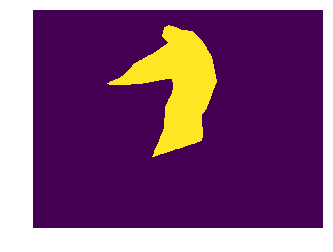

In [158]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

I = Image.open(urlopen(img['coco_url']))#io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
# coco.showAnns(anns)

mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)
print(mask.shape)

In [28]:
class COCODataLoader(Sequence):
    """
    """
    
    def __init__(self, batch_size, path_to_annotations, path_to_images, resize=None, shuffle=True):
        self.dataset = COCO(path_to_annotations)
        self.path_to_images = path_to_images
        self.batch_size = batch_size
        self.categories_ids = self.dataset.getCatIds(catNms=['person']);
        self.images_ids = self.dataset.getImgIds(catIds=self.categories_ids);
        self.images_descriptions = np.asanyarray(self.dataset.loadImgs(self.images_ids))
        self.resize = resize
        self.shuffle = shuffle
        
        if self.shuffle:
            np.random.shuffle(self.images_descriptions)
    
    
    def __len__(self):
        return int(np.ceil(len(self.images_ids) / float(self.batch_size)))
    
    
    def __getitem__(self, index):
        images = []
        masks = []
        batch_descriptions = self.images_descriptions[index*self.batch_size : (index+1)*self.batch_size]

        for desc in batch_descriptions:
            # Load image
            image_filename = os.path.join(self.path_to_images, desc['file_name'])
            image = img_to_array(load_img(image_filename))

            # Load masks for this image
            batch_annotations_ids = self.dataset.getAnnIds(imgIds=desc['id'], catIds=self.categories_ids, iscrowd=None)
            annotations = self.dataset.loadAnns(batch_annotations_ids)
            mask = self.dataset.annToMask(annotations[0])
            for i in range(len(annotations)):
                mask += self.dataset.annToMask(annotations[i])
            
            # Make binary mask
            mask = np.where(mask >= 1., 1., 0)
            
            # Resize image and mask
            if self.resize:
                image = skt.resize(image, self.resize, anti_aliasing=False)
                image /= 255.0
                mask = np.round(skt.resize(mask, self.resize, anti_aliasing=False))
            
            # Augmentations
            aug = Compose([
                HorizontalFlip(  p=0.3),
                RandomSizedCrop( p=.3, min_max_height=(0, 224), height=self.resize[0], width=self.resize[1]),
                GridDistortion(  p=.3, border_mode=0, distort_limit=0.1),
                ElasticTransform(p=.3, alpha=10, sigma=120 * 0.5, alpha_affine=120 * 0.05),
                ShiftScaleRotate(p=.3, border_mode=0, shift_limit=0.04, scale_limit=0.05),
                OneOf([
                    RandomBrightnessContrast(p=.3),    
                    RandomGamma(p=.3)
                ], p=1)
              ])
            augmented = aug(image=image, mask=mask)
            
            images.append(augmented['image'])
            masks.append(augmented['mask'])
            
        return np.asanyarray(images), np.asanyarray(masks)
    
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images_descriptions)

In [29]:
d = COCODataLoader(batch_size=32,
                   resize=(224,224),
                   path_to_annotations='/home/matsvei.rozanau/hdd/datasets/coco_dataset/annotations/instances_train2017.json',
                   path_to_images='/home/matsvei.rozanau/hdd/datasets/coco_dataset/train2017/')

loading annotations into memory...
Done (t=12.58s)
creating index...
index created!


In [30]:
# %%timeit
images, masks = d[0]

In [33]:
masks.shape

(32, 224, 224)

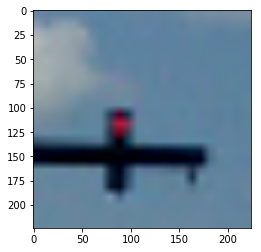

In [34]:
plt.imshow(images[3])

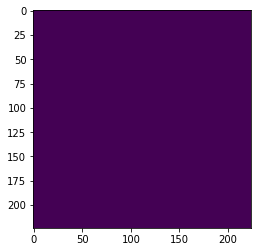

In [35]:
plt.imshow(masks[3])

In [286]:
########### AUGMENTATIONS TEST ###############

In [32]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

(224, 224, 3) (224, 224)


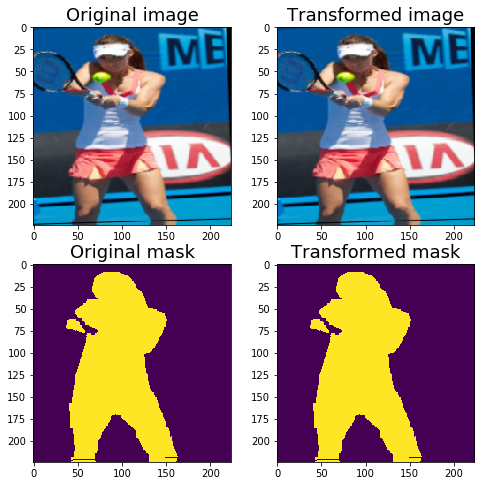

In [36]:
idx = 21
image, mask = images[idx], masks[idx]
original_width, original_height = 224,224

aug = PadIfNeeded(p=1, min_height=224, min_width=224)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)
visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

(224, 224, 3) (224, 224)


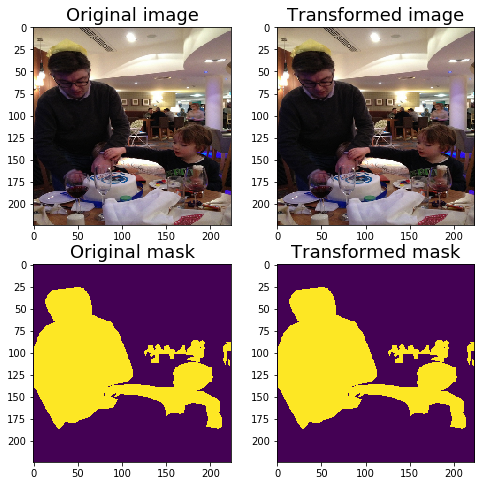

In [347]:
aug = CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

(65, 90, 3) (65, 90)


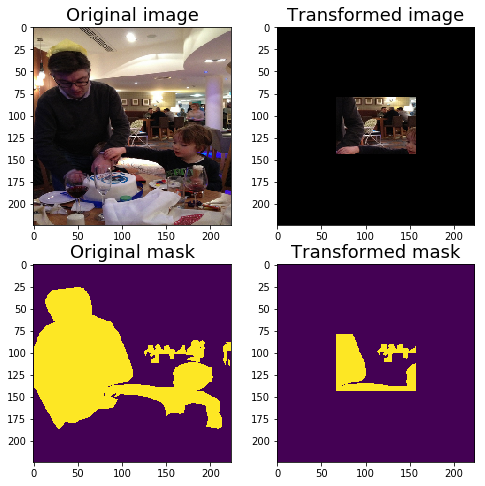

In [396]:
xs_min = np.array([x for x in range(0, 112)])
ys_min = np.array([x for x in range(0, 112)])
xs_max = np.array([x for x in range(128, 224)])
ys_max = np.array([x for x in range(128, 224)])

aug = Crop(p=1, 
           x_min=np.random.choice(xs_min, 1)[0], 
           x_max=np.random.choice(xs_max, 1)[0], 
           y_min=np.random.choice(ys_min, 1)[0], 
           y_max=np.random.choice(ys_max, 1)[0])
augmented = aug(image=image, mask=mask)
image_cropped = augmented['image']
mask_cropped = augmented['mask']

print(image_cropped.shape, mask_cropped.shape)

aug = PadIfNeeded(p=1, min_height=224, min_width=224, border_mode=0)
augmented = aug(image=image_cropped, mask=mask_cropped)
image_padded = augmented['image']
mask_padded = augmented['mask']

# assert (image - image_cropped).sum() == 0
# assert (mask - mask_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

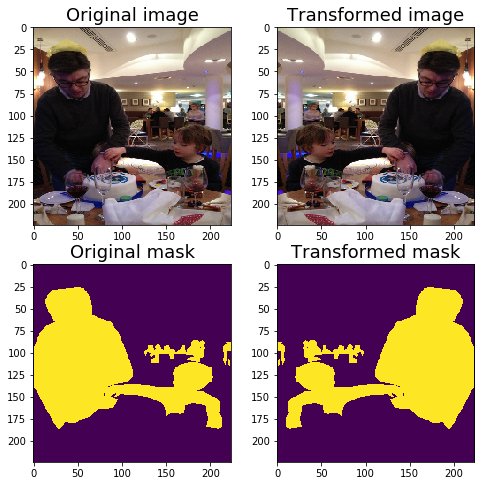

In [398]:
aug = HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

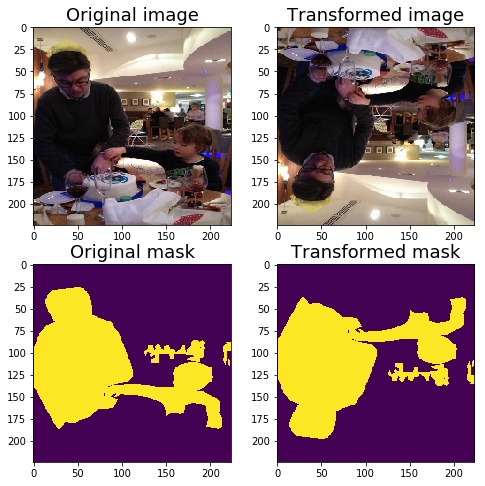

In [400]:
aug = VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

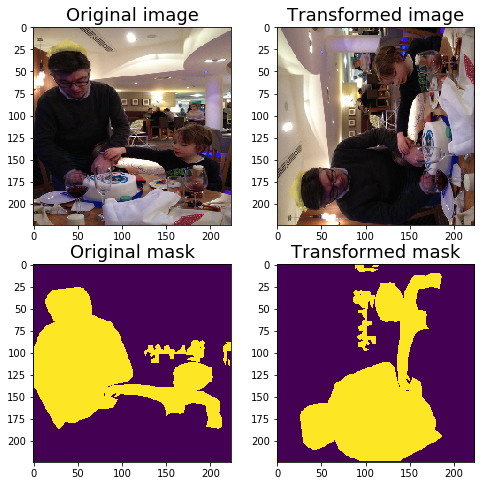

In [405]:
aug = RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

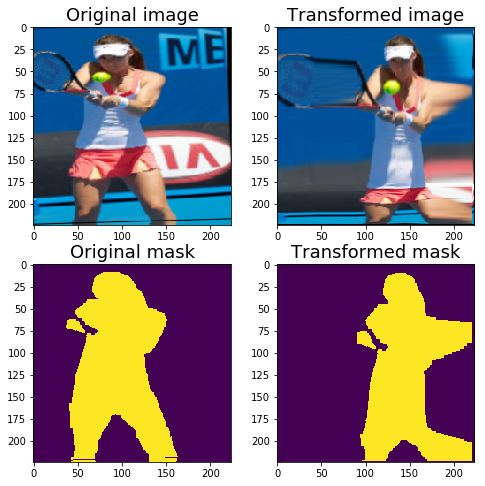

In [39]:


aug = GridDistortion(p=1, border_mode=0, distort_limit=1)

augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)



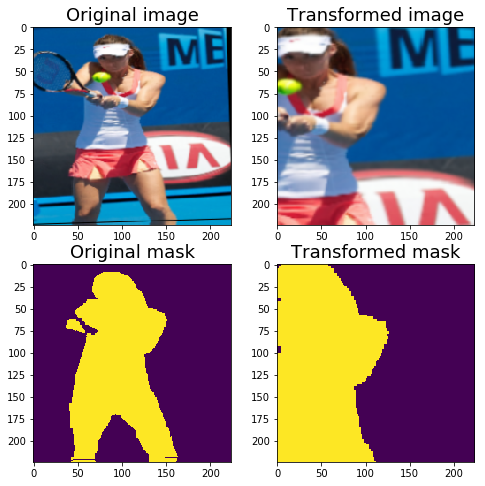

In [50]:
aug = RandomSizedCrop(p=1, min_max_height=(0, 224), height=original_height, width=original_width)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

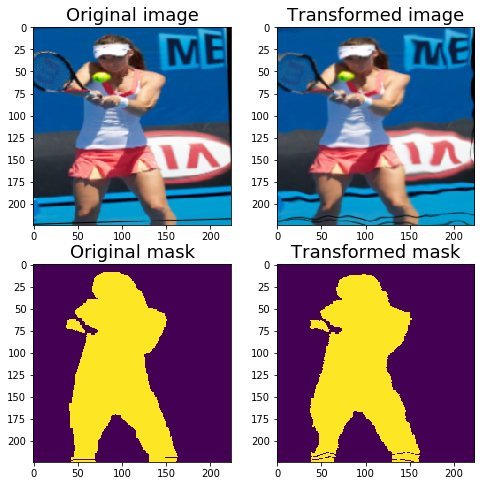

In [45]:
aug = ElasticTransform(p=1, alpha=50, sigma=120 * 0.05, alpha_affine=120 * 0.05)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

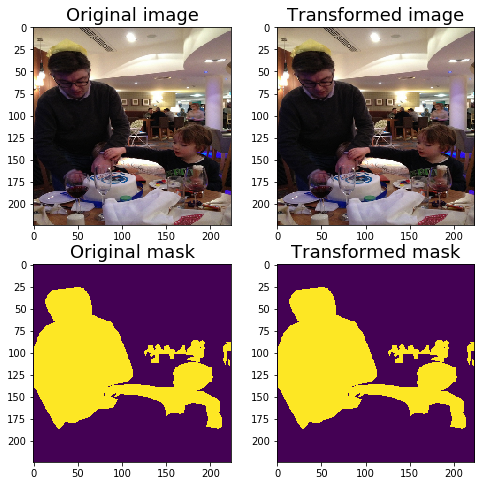

In [532]:
aug = ShiftScaleRotate(border_mode=0, shift_limit=0.04)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

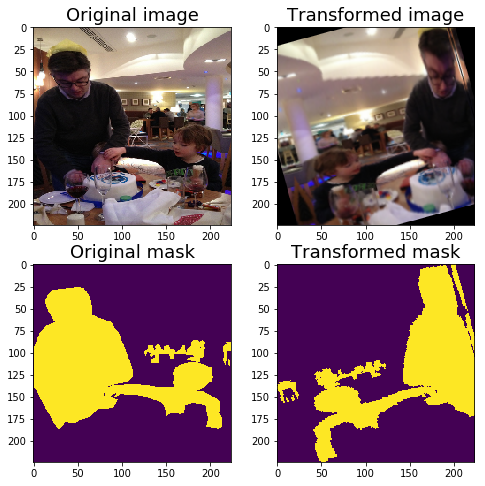

In [587]:
aug = Compose([HorizontalFlip(p=0.5),              
              RandomSizedCrop(p=.5, min_max_height=(0, 224), height=original_height, width=original_width),
              GridDistortion(p=.5, border_mode=0, distort_limit=0.5),
              ElasticTransform(p=.5, alpha=10, sigma=120 * 0.5, alpha_affine=120 * 0.05),
#                HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1)`
               ShiftScaleRotate(scale_limit=0.1, border_mode=0)
              ])

augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize(image_light, mask_light, original_image=image, original_mask=mask)


In [636]:
from data_generator.data_generator import COCODataLoader

In [645]:
train_gen = COCODataLoader(path_to_annotations='/home/matsvei.rozanau/hdd/datasets/coco_dataset/annotations/instances_train2017.json',
                   path_to_images='/home/matsvei.rozanau/hdd/datasets/coco_dataset/train2017/',
                   batch_size=32,
                   resize=(224,224),
                   augmentations=True)

val_gen = COCODataLoader(path_to_annotations='/home/matsvei.rozanau/hdd/datasets/coco_dataset/annotations/instances_val2017.json',
                   path_to_images='/home/matsvei.rozanau/hdd/datasets/coco_dataset/val2017/',
                   batch_size=32,
                   resize=(224,224),
                   augmentations=True)

loading annotations into memory...
Done (t=14.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [646]:
batch = val_gen[2]

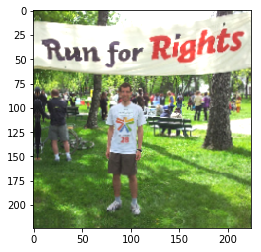

In [664]:
plt.imshow(batch[0][31])

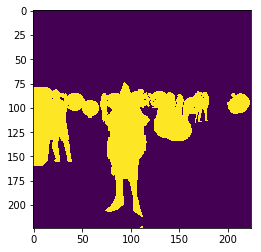

In [665]:
plt.imshow(batch[1][31])